<b><font color="SteelBlue" size="+3">Classifiez automatiquement des biens de consommation</font></b>

# Introduction

Ce notebook est la suite de celui sur le traitement des descriptions. On récupère les données nettoyées pour les catégories des produits.

## Imports

In [1]:
# Chargement des librairies
# Standard
import os

# Data Manipulation and Analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from matplotlib.image import imread
from PIL import Image as PilImage

# Deep Learning - TensorFlow/Keras
os.environ["KERAS_BACKEND"] = "torch"
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inceptionresnetv2
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet201
from tensorflow.keras.utils import to_categorical

# Custom Modules
from Deveau_Estelle_4_IMG_func_042024 import *

## Data

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'data',
 'Deveau_Estelle_1_notebook_txt_faisabilite_042024.ipynb',
 'Deveau_Estelle_2_NLP_func_042024.py',
 'Deveau_Estelle_3_notebook_img_faisabilite_042024.ipynb',
 'Deveau_Estelle_4_IMG_func_042024.py',
 'Deveau_Estelle_5_notebook_img_classification_042024.ipynb',
 'model_augmented_best.weights.h5',
 'model_augmented_data_best.weights.h5',
 'model_augmented_data_best_with_generator.weights.h5',
 'model_augmented_data_best_with_seq.weights.h5',
 'model_best.keras',
 'model_best.weights.h5',
 'model_densenet201_best.weights.h5',
 'model_inceptionresnetv2_best.weights.h5',
 'model_iresnetv2_ad_best.weights.h5',
 'model_vgg16_best.weights.h5',
 'OC_projet6.pptx',
 'pythonProject',
 'svg',
 'Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb',
 'Weather_Images_CNN_Transfer_Learning_Stage_2_supervised_classification_V1.0.ipynb',
 '__pycache__']

In [3]:
os.listdir("data/Cleaned/")

['data.csv']

In [4]:
path     = "./data/Cleaned/"
filename = "data.csv"

In [5]:
data = pd.read_csv(path + filename)

In [6]:
path     = "./data/Sources/Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

1050


# Classification supervisée

In [7]:
cols_to_keep = ['uniq_id', 'product_category']
df = data[cols_to_keep]
df.head(5)

,uniq_id,product_category
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing


In [8]:
image_paths = [f"{path}{uid}.jpg" for uid in df['uniq_id']]

# Encodage des catégories
label_encoder = LabelEncoder()
categories_encoded = label_encoder.fit_transform(df['product_category'])
category_names = label_encoder.classes_

## Séparation des jeux de données (train, val, test)

In [9]:
y = to_categorical(categories_encoded, 7)

In [10]:
y[:5]

array([[0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.]])

In [11]:
# Diviser les chemins d'image et les étiquettes
paths_train, paths_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, random_state=42)
paths_train, paths_val, y_train, y_val = train_test_split(paths_train, y_train, test_size=0.25, random_state=42)

In [12]:
y_test[:5]

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]])

In [13]:
# Dictionnaire pour stocker les résultats
results = {}

## Evaluation des modèles sélectionnés

In [14]:
# Définir le seuil à un niveau supérieur spécifique
PilImage.MAX_IMAGE_PIXELS = 100000000

### VGG16

In [15]:
# Préparation des données
X_train_vgg16, X_val_vgg16, X_test_vgg16 = prepare_data(paths_train, paths_val, paths_test, preprocess_vgg16,
                                                        target_size=(224, 224, 3))

In [16]:
# Création du modèle
model_vgg16 = create_model_fct(base_model_name='VGG16')

In [17]:
# Entraînement du modèle
model_vgg16, history_vgg16, duration_vgg16 = train_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16, y_val,
                                                         model_save_path="./model_vgg16_best.weights.h5")

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3586 - loss: 6.1242
Epoch 1: val_loss improved from inf to 1.41619, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.3638 - loss: 6.0560 - val_accuracy: 0.7286 - val_loss: 1.4162
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6932 - loss: 2.2511
Epoch 2: val_loss improved from 1.41619 to 1.05836, saving model to ./model_vgg16_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.6933 - loss: 2.2427 - val_accuracy: 0.7905 - val_loss: 1.0584
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7689 - loss: 1.4193
Epoch 3: val_loss did not improve from 1.05836
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7690 - loss: 1.4156 - val_accuracy: 0.7714 - val_loss: 1.0896
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8104 - loss: 1.0706
Epoch 4: val_loss improved from 1.05836 to 0.92641, saving model t

In [18]:
# Évaluation du modèle
loss_vgg16, accuracy_vgg16, ari_score_vgg16 = evaluate_model(model_vgg16, X_train_vgg16, y_train, X_val_vgg16,
                                                             y_val, X_test_vgg16, y_test, best_weights_path="./model_vgg16_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9920 - loss: 0.0381
Training Accuracy after last epoch: 0.9921

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8473 - loss: 0.7256
Test Accuracy after last epoch: 0.8333

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7997 - loss: 0.7583
Validation Accuracy (best): 0.7857
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.8338 - loss: 0.6914
Test Accuracy (best): 0.8238
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Adjusted Rand Index (ARI): 0.6376


### InceptionResNetV2

In [19]:
# Préparation des données
X_train_inceptionresnetv2, X_val_inceptionresnetv2, X_test_inceptionresnetv2 = prepare_data(paths_train, paths_val,
                                                                                            paths_test, preprocess_inceptionresnetv2,
                                                                                            target_size=(299, 299, 3))

In [20]:
# Création du modèle
model_inceptionresnetv2 = create_model_fct(base_model_name='InceptionResNetV2')

In [21]:
# Entraînement du modèle
model_iresnetv2, history_iressnetv2, duration_iresnetv2 = train_model(model_inceptionresnetv2, X_train_inceptionresnetv2,
                                                                      y_train, X_val_inceptionresnetv2, y_val,
                                                                      model_save_path="./model_inceptionresnetv2_best.weights.h5")

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.4468 - loss: 1.7683
Epoch 1: val_loss improved from inf to 1.06543, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.4552 - loss: 1.7445 - val_accuracy: 0.5857 - val_loss: 1.0654
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7420 - loss: 0.7602
Epoch 2: val_loss improved from 1.06543 to 0.57158, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 339ms/step - accuracy: 0.7442 - loss: 0.7565 - val_accuracy: 0.8143 - val_loss: 0.5716
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8602 - loss: 0.5026
Epoch 3: val_loss improved from 0.57158 to 0.40353, saving model to ./model_inceptionresnetv2_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 337ms/step - accuracy: 0.8602 - loss: 0.5015 - val_accuracy: 0.8619 - val_loss: 0.4035
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0

In [22]:
# Évaluation du modèle
loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2 = evaluate_model(model_iresnetv2,
                                                                                                 X_train_inceptionresnetv2,
                                                                                                 y_train, X_val_inceptionresnetv2,
                                                                                                 y_val, X_test_inceptionresnetv2,
                                                                                                 y_test,
                                                                                                 best_weights_path="./model_inceptionresnetv2_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.9955 - loss: 0.0342
Training Accuracy after last epoch: 0.9937

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.8702 - loss: 0.4807
Test Accuracy after last epoch: 0.8667

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8736 - loss: 0.3923
Validation Accuracy (best): 0.8857
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.8709 - loss: 0.5040
Test Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step
Adjusted Rand Index (ARI): 0.7497


### DenseNet201

In [23]:
# Préparation des données
X_train_densenet201, X_val_densenet201, X_test_densenet201 = prepare_data(paths_train, paths_val, paths_test,
                                                                          preprocess_densenet201, target_size=(224, 224, 3))


In [24]:
# Création du modèle
model_densenet201 = create_model_fct(base_model_name='DenseNet201')


In [25]:
# Entraînement du modèle
model_densenet201, history_densenet201, duration_densenet201 = train_model(model_densenet201, X_train_densenet201, y_train,
                                                                           X_val_densenet201, y_val,
                                                                           model_save_path="./model_densenet201_best.weights.h5")


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.4090 - loss: 1.9487
Epoch 1: val_loss improved from inf to 0.71545, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.4159 - loss: 1.9225 - val_accuracy: 0.7619 - val_loss: 0.7154
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8110 - loss: 0.6304
Epoch 2: val_loss improved from 0.71545 to 0.54664, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - accuracy: 0.8114 - loss: 0.6287 - val_accuracy: 0.8429 - val_loss: 0.5466
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8764 - loss: 0.4315
Epoch 3: val_loss improved from 0.54664 to 0.50290, saving model to ./model_densenet201_best.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 534ms/step - accuracy: 0.8760 - loss: 0.4326 - val_accuracy: 0.8143 - val_loss: 0.5029
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9036 - loss: 0.

In [26]:
# Évaluation du modèle
loss_densenet201, accuracy_densenet201, ari_score_densenet201 = evaluate_model(model_densenet201, X_train_densenet201,
                                                                               y_train, X_val_densenet201,
                                                                                y_val, X_test_densenet201, y_test,
                                                                               best_weights_path="./model_densenet201_best.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.9866 - loss: 0.0632
Training Accuracy after last epoch: 0.9841

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - accuracy: 0.8245 - loss: 0.5534
Test Accuracy after last epoch: 0.8333

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.8102 - loss: 0.5145
Validation Accuracy (best): 0.8143
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step - accuracy: 0.8341 - loss: 0.4846
Test Accuracy (best): 0.8381
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step
Adjusted Rand Index (ARI): 0.6554


### Comparaison des résultats

In [31]:
# Initialisation de la liste pour stocker les résultats
data_results = []

# Fonction pour ajouter les résultats d'un modèle au DataFrame
def add_results(model_name, loss, accuracy, ari_score, duration):
    metrics = ['Loss', 'Accuracy', 'Adjusted Rand Score', 'Duration (en heures)']
    scores = [loss, accuracy, ari_score, (duration/3600)]
    for metric, score in zip(metrics, scores):
        data_results.append({
            'Model': model_name,
            'Metric': metric,
            'Score': score
        })

In [32]:
add_results('VGG16', loss_vgg16, accuracy_vgg16, ari_score_vgg16, duration_vgg16)
add_results('InceptionResNetV2', loss_inceptionresnetv2, accuracy_inceptionresnetv2, ari_score_inceptionresnetv2, duration_iresnetv2)
add_results('DenseNet201', loss_densenet201, accuracy_densenet201, ari_score_densenet201, duration_densenet201)

data_metrics = pd.DataFrame(data_results)

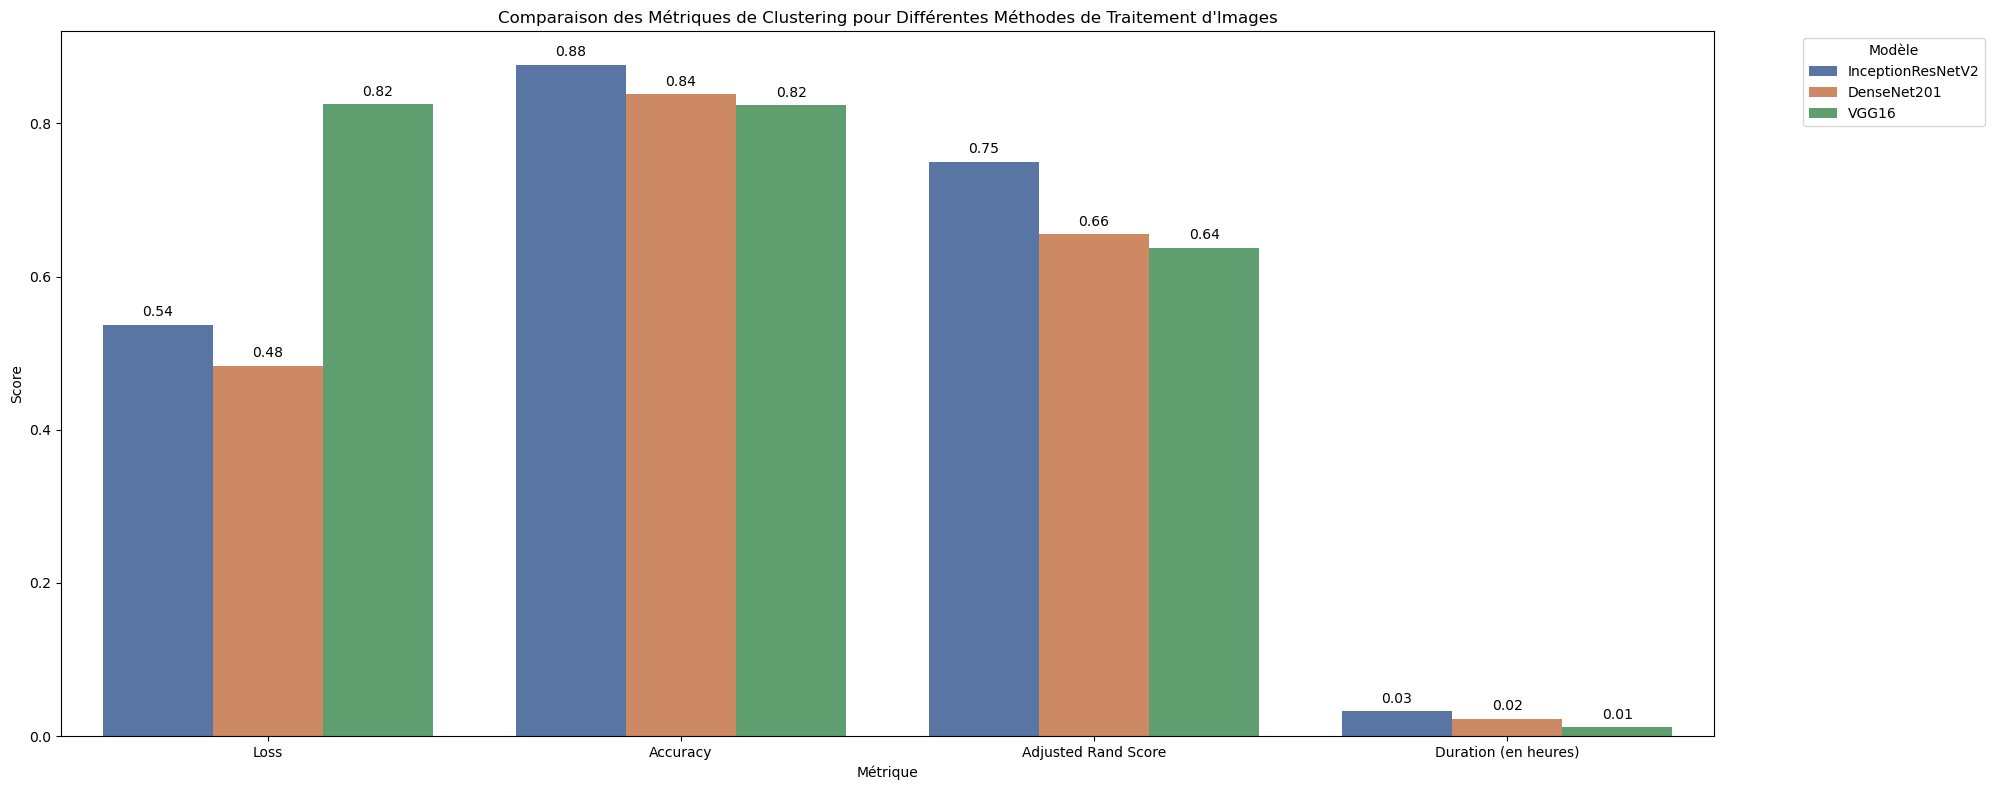

In [33]:
plot_model_performance(data_metrics)

# Optimisation

## Hyper paramètres

In [34]:
# Entraînement du modèle
best_model, duration_best = test_hyperparameters(model_inceptionresnetv2, X_train_inceptionresnetv2, y_train, X_val_inceptionresnetv2,
                                                 y_val, "./model_best.weights.h5")

Testing with learning_rate=0.01, batch_size=16, epochs=50
Epoch 14: early stopping
Restoring model weights from the end of the best epoch: 9.
Finished 0.01, 16 with val_accuracy=0.8666666746139526, duration=382.9518332481384
Testing with learning_rate=0.01, batch_size=32, epochs=50
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
Finished 0.01, 32 with val_accuracy=0.8666666746139526, duration=105.9016523361206
Testing with learning_rate=0.01, batch_size=64, epochs=50
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Finished 0.01, 64 with val_accuracy=0.8761904835700989, duration=311.8325831890106
Testing with learning_rate=0.001, batch_size=16, epochs=50
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
Finished 0.001, 16 with val_accuracy=0.8714285492897034, duration=232.91986989974976
Testing with learning_rate=0.001, batch_size=32, epochs=50
Epoch 5: early stopping
Restoring model w

In [35]:
# Évaluation du modèle
loss_best, accuracy_best, ari_score_best = evaluate_model(best_model,
                                                          X_train_inceptionresnetv2,
                                                          y_train, X_val_inceptionresnetv2,
                                                          y_val, X_test_inceptionresnetv2,
                                                          y_test, best_weights_path="none")

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8763 - loss: 0.7616
Validation Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8911 - loss: 0.6141
Test Accuracy (best): 0.8810
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Adjusted Rand Index (ARI): 0.7597


In [36]:
add_results('InceptionResNetV2(HP)', loss_best, accuracy_best, ari_score_best, duration_best)
data_metrics = pd.DataFrame(data_results)

In [37]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.824726
1,VGG16,Accuracy,0.823810
2,VGG16,Adjusted Rand Score,0.637627
3,VGG16,Duration (en heures),0.011652
4,InceptionResNetV2,Loss,0.537020
5,InceptionResNetV2,Accuracy,0.876190
6,InceptionResNetV2,Adjusted Rand Score,0.749733
7,InceptionResNetV2,Duration (en heures),0.032615
8,DenseNet201,Loss,0.483324
9,DenseNet201,Accuracy,0.838095


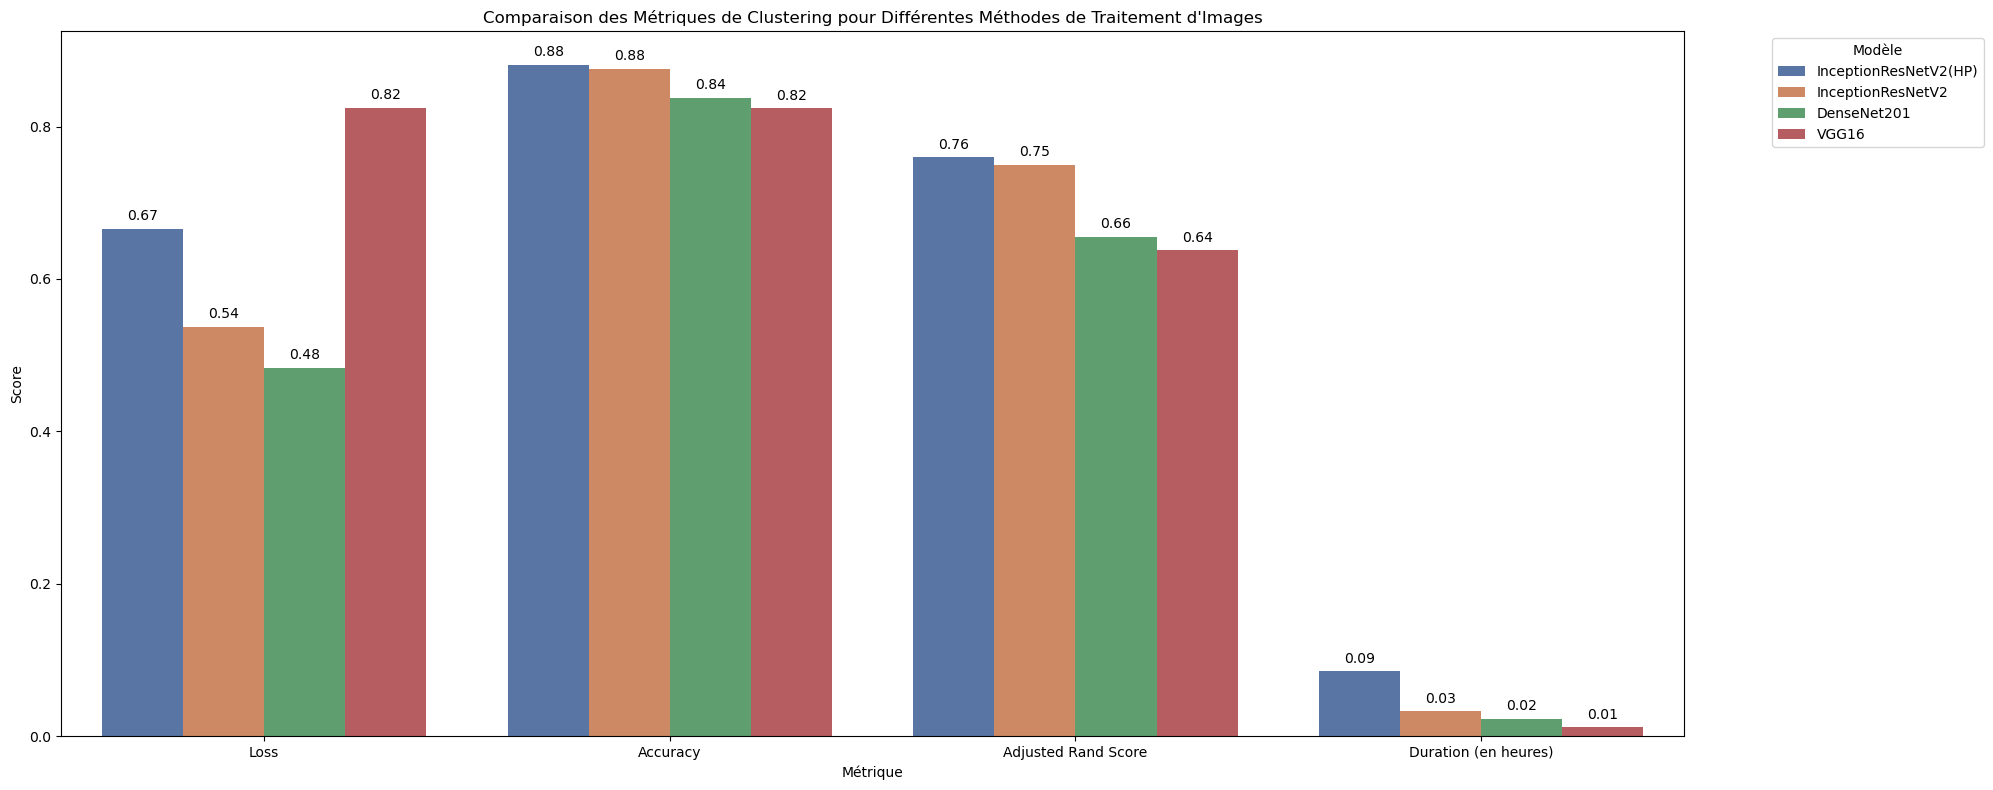

In [38]:
plot_model_performance(data_metrics)

## Data Augmentation

### ImageDataGenerator

In [39]:
train_generator, validation_generator = prepare_augmented_data(X_train_inceptionresnetv2, y_train, X_val_inceptionresnetv2, y_val)


In [40]:
model_with_generator, history_with_generator, duration_with_generator = train_model_with_generator(model_iresnetv2, train_generator,
                                                                                                   validation_generator,
                                                                                                   "./model_augmented_data_best_with_generator.weights.h5")

C:\Users\estel\anaconda3\envs\OC\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1319 - loss: 4.8988
Epoch 1: val_loss improved from inf to 2.02831, saving model to ./model_augmented_data_best_with_generator.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.1316 - loss: 4.8447 - val_accuracy: 0.1524 - val_loss: 2.0283
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1467 - loss: 2.2370
Epoch 2: val_loss improved from 2.02831 to 1.95384, saving model to ./model_augmented_data_best_with_generator.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.1467 - loss: 2.2334 - val_accuracy: 0.1476 - val_loss: 1.9538
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1501 - loss: 1.9991
Epoch 3: val_loss did not improve from 1.95384
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.1493 - loss: 1.9984 - val_accuracy: 0.1476 - val_loss: 1.9558
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1417 - loss: 1.9542
Epoch 4: val_loss improved from 1.95

In [41]:
loss_test_with_generator, accuracy_test_with_generator, ari_score_with_generator = evaluate_model_with_generators(model_with_generator, train_generator,
                                                                                                                  validation_generator,
                                                                                                                  X_test_inceptionresnetv2, y_test, 
                                                                                                                  "./model_augmented_data_best_with_generator.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.1616 - loss: 1.9441
Training Accuracy (best): 0.1460
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.1465 - loss: 1.9498
Validation Accuracy (best): 0.1476
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9012 - loss: 0.4849
Test Accuracy (best): 0.8857
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Adjusted Rand Index (ARI): 0.7714


In [42]:
add_results('InceptionResNetV2(ImageDataGenerator)', loss_test_with_generator, accuracy_test_with_generator, ari_score_with_generator,
            duration_with_generator)
data_metrics = pd.DataFrame(data_results)

In [43]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.824726
1,VGG16,Accuracy,0.823810
2,VGG16,Adjusted Rand Score,0.637627
3,VGG16,Duration (en heures),0.011652
4,InceptionResNetV2,Loss,0.537020
5,InceptionResNetV2,Accuracy,0.876190
6,InceptionResNetV2,Adjusted Rand Score,0.749733
7,InceptionResNetV2,Duration (en heures),0.032615
8,DenseNet201,Loss,0.483324
9,DenseNet201,Accuracy,0.838095


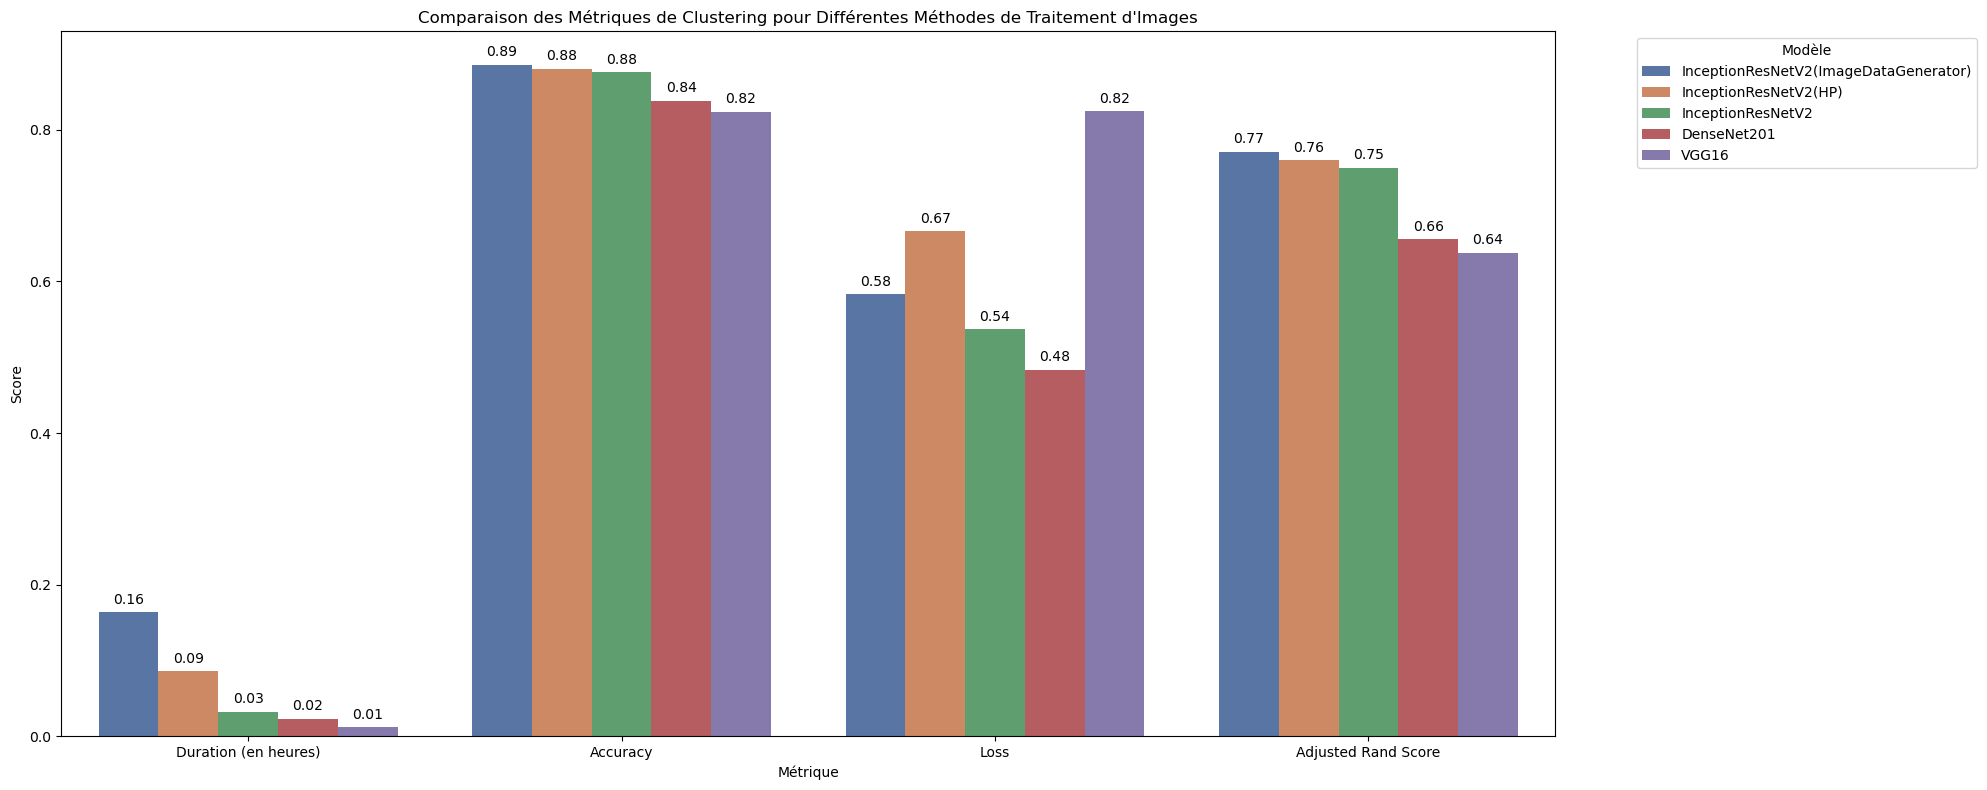

In [44]:
plot_model_performance(data_metrics)

### Sequential

In [45]:
# Création du modèle séquentiel basé sur InceptionResNetV2
sequential_model_inceptionresnetv2 = create_sequential_model()

In [46]:
# Entraînement du modèle avec l'approche Sequential
model_with_sequential, history_with_sequential, duration_with_sequential = train_model(sequential_model_inceptionresnetv2,
                                                                                       X_train_inceptionresnetv2, y_train,
                                                                                       X_val_inceptionresnetv2, y_val,
                                                                                       "./model_augmented_data_best_with_seq.weights.h5"
                                                                                       )

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3412 - loss: 1.9678
Epoch 1: val_loss improved from inf to 13.71521, saving model to ./model_augmented_data_best_with_seq.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 154s 8s/step - accuracy: 0.3468 - loss: 1.9528 - val_accuracy: 0.1476 - val_loss: 13.7152
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6670 - loss: 1.0227
Epoch 2: val_loss improved from 13.71521 to 6.13902, saving model to ./model_augmented_data_best_with_seq.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 173s 9s/step - accuracy: 0.6686 - loss: 1.0179 - val_accuracy: 0.3810 - val_loss: 6.1390
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7310 - loss: 0.8238
Epoch 3: val_loss improved from 6.13902 to 3.41736, saving model to ./model_augmented_data_best_with_seq.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 185s 9s/step - accuracy: 0.7310 - loss: 0.8243 - val_accuracy: 0.4048 - val_loss: 3.4174
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accur

In [47]:
# Évaluation du modèle
loss_with_sequential, accuracy_with_sequential, ari_score_with_sequential = evaluate_model(sequential_model_inceptionresnetv2,
                                                                                           X_train_inceptionresnetv2, y_train,
                                                                                           X_val_inceptionresnetv2, y_val,
                                                                                           X_test_inceptionresnetv2, y_test,
                                                                                           "./model_augmented_data_best_with_seq.weights.h5")

20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.3176 - loss: 10.3625
Training Accuracy after last epoch: 0.3063

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.3158 - loss: 10.4026
Test Accuracy after last epoch: 0.2762

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3768 - loss: 3.5285
Validation Accuracy (best): 0.4048
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.3744 - loss: 4.2107
Test Accuracy (best): 0.3905
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Adjusted Rand Index (ARI): 0.1486


In [48]:
add_results('InceptionResNetV2(Sequential)', loss_with_sequential, accuracy_with_sequential, ari_score_with_sequential,
            duration_with_sequential)
data_metrics = pd.DataFrame(data_results)

In [49]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.824726
1,VGG16,Accuracy,0.823810
2,VGG16,Adjusted Rand Score,0.637627
3,VGG16,Duration (en heures),0.011652
4,InceptionResNetV2,Loss,0.537020
5,InceptionResNetV2,Accuracy,0.876190
6,InceptionResNetV2,Adjusted Rand Score,0.749733
7,InceptionResNetV2,Duration (en heures),0.032615
8,DenseNet201,Loss,0.483324
9,DenseNet201,Accuracy,0.838095


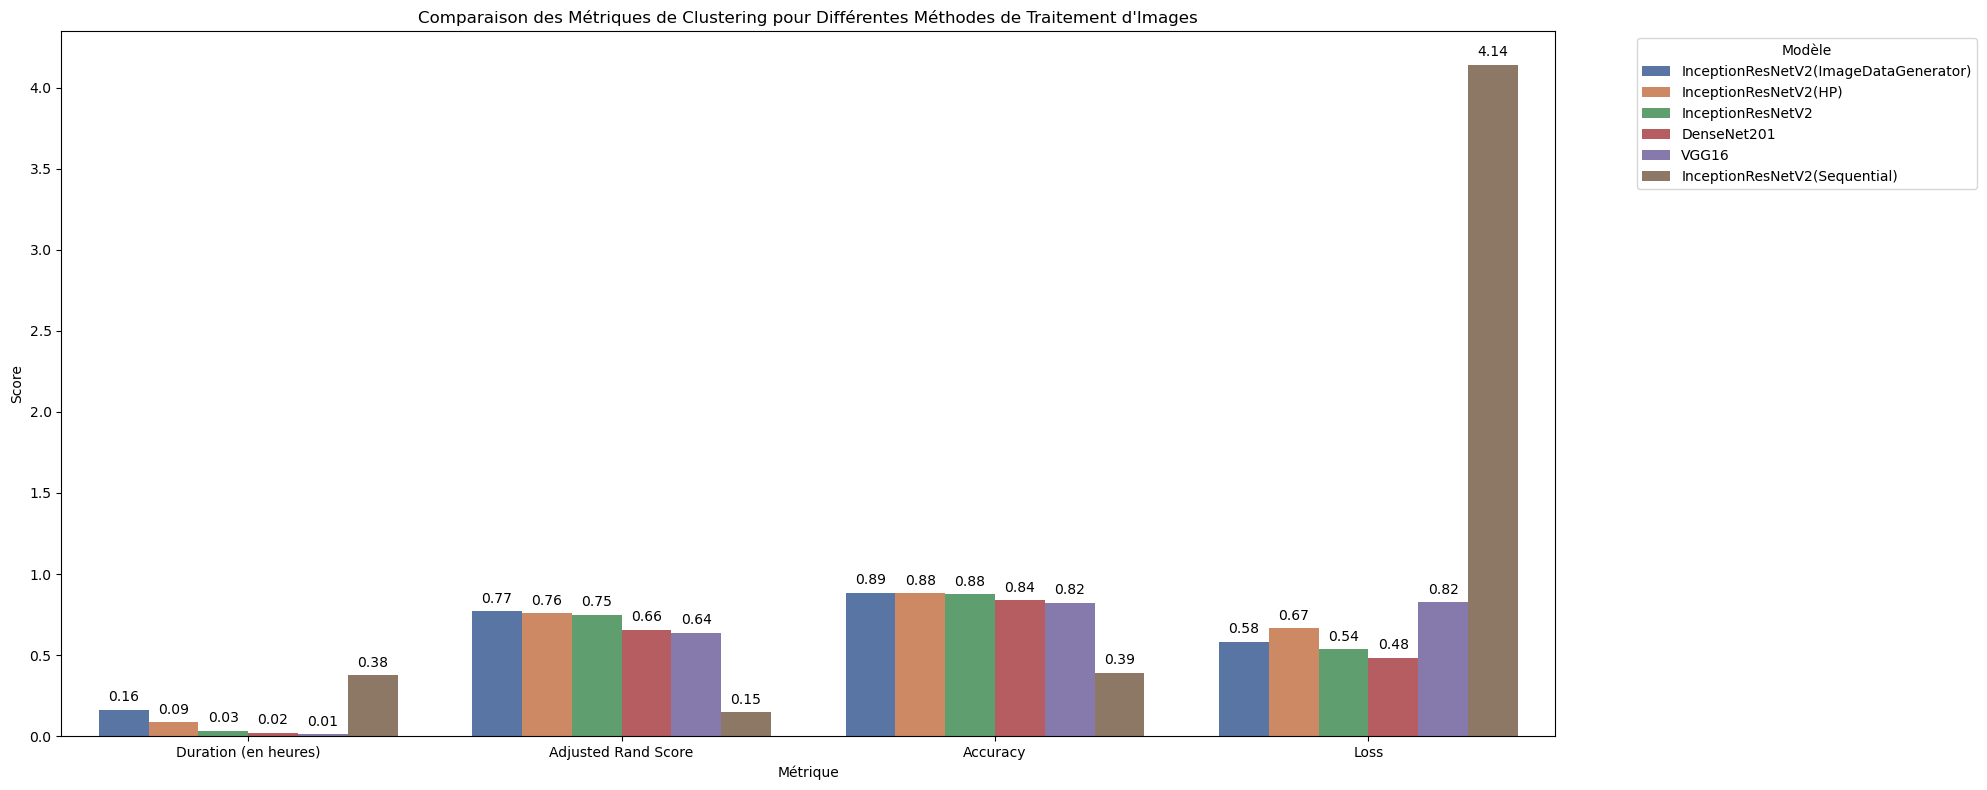

In [50]:
plot_model_performance(data_metrics)

### IA Generative

Utilisation de Copilot et du prompt :
"Créez une image haute résolution de [objet] sur un fond strictement blanc. Le sujet doit être vu de côté, montrant ses formes et caractéristiques distinctives. Assurez-vous que l'éclairage est parfaitement uniforme pour éliminer toutes les ombres sur le sujet et le fond. Le fond doit rester complètement blanc, sans nuances, textures ou autres éléments. L'image doit mettre en valeur uniquement le sujet, idéal pour des présentations de produit."

In [51]:
# Répertoires correspondant aux catégories
repertoires = {
    'Home Furnishing': "./data/Sources/generatedimages/homefurnishing",
    'Baby Care': "./data/Sources/generatedimages/baby",
    'Watches': "./data/Sources/generatedimages/watches",
    'Home Decor & Festive Needs': "./data/Sources/generatedimages/homedecor",
    'Kitchen & Dining': "./data/Sources/generatedimages/kitchen",
    'Beauty and Personal Care': "./data/Sources/generatedimages/beauty",
    'Computers': "./data/Sources/generatedimages/computers"
}

In [52]:
# Initialisation des listes pour les chemins d'image et les étiquettes
paths_train_gen = paths_train.copy()
y_train_gen = y_train.copy()

In [53]:
# Obtenir les catégories dans l'ordre d'encodage
categories = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Parcourir tous les répertoires
for categorie, repertoire in repertoires.items():
    # Récupérer l'indice de la catégorie dans l'encodage des catégories
    index_categorie = label_encoder.transform([categorie])[0]

    # Parcourir les images dans le répertoire
    for img in os.listdir(repertoire):
        # Créer le chemin complet de l'image
        chemin_image = os.path.join(repertoire, img)

        # Ajouter le chemin de l'image
        paths_train_gen.append(chemin_image)

        # Créer l'étiquette correspondante pour cette catégorie
        y_imggen_train = np.zeros(7)
        y_imggen_train[index_categorie] = 1

        # Ajouter l'étiquette
        y_train_gen = np.vstack([y_train_gen, y_imggen_train])

# Convertir les listes en tableaux numpy
paths_train_gen = np.array(paths_train_gen)

In [54]:
# Préparation des données
X_train_iresnetv2_ad, X_val_iresnetv2_ad, X_test_iresnetv2_ad = prepare_data(paths_train_gen, paths_val,
                                                                             paths_test, preprocess_inceptionresnetv2,
                                                                             target_size=(299, 299, 3))

In [55]:
# Entraînement du modèle
model_iresnetv2_ad, history_iresnetv2_ad, duration_iresnetv2_ad = train_model(model_iresnetv2, X_train_iresnetv2_ad,
                                                                              y_train_gen, X_val_iresnetv2_ad, y_val,
                                                                              model_save_path="./model_iresnetv2_ad_best.weights.h5")

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8993 - loss: 0.4088
Epoch 1: val_loss improved from inf to 0.71115, saving model to ./model_iresnetv2_ad_best.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.8995 - loss: 0.4064 - val_accuracy: 0.8524 - val_loss: 0.7111
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9283 - loss: 0.2603
Epoch 2: val_loss did not improve from 0.71115
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9284 - loss: 0.2627 - val_accuracy: 0.8524 - val_loss: 0.7288
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9401 - loss: 0.3806
Epoch 3: val_loss did not improve from 0.71115
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9396 - loss: 0.3774 - val_accuracy: 0.8619 - val_loss: 0.7204
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9264 - loss: 0.3409
Epoch 4: val_loss did not improve from 0.71115
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.9267 - loss: 0.3398 - val_ac

In [56]:
# Évaluation du modèle
loss_iresnetv2_ad, accuracy_iresnetv2_ad, ari_score_iresnetv2_ad = evaluate_model(model_iresnetv2_ad,
                                                                                  X_train_iresnetv2_ad,
                                                                                  y_train_gen, X_val_iresnetv2_ad,
                                                                                  y_val, X_test_iresnetv2_ad,
                                                                                  y_test,
                                                                                  best_weights_path="./model_iresnetv2_ad_best.weights.h5")

24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9785 - loss: 0.1533
Training Accuracy after last epoch: 0.9735

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8735 - loss: 0.6380
Test Accuracy after last epoch: 0.8667

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8709 - loss: 0.6959
Validation Accuracy (best): 0.8762
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8971 - loss: 0.5588
Test Accuracy (best): 0.8905
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
Adjusted Rand Index (ARI): 0.7744


In [57]:
add_results('InceptionResNetV2(IA Generative)', loss_iresnetv2_ad, accuracy_iresnetv2_ad,
            ari_score_iresnetv2_ad, duration_iresnetv2_ad)
data_metrics = pd.DataFrame(data_results)

In [58]:
data_metrics

,Model,Metric,Score
0,VGG16,Loss,0.824726
1,VGG16,Accuracy,0.823810
2,VGG16,Adjusted Rand Score,0.637627
3,VGG16,Duration (en heures),0.011652
4,InceptionResNetV2,Loss,0.537020
5,InceptionResNetV2,Accuracy,0.876190
6,InceptionResNetV2,Adjusted Rand Score,0.749733
7,InceptionResNetV2,Duration (en heures),0.032615
8,DenseNet201,Loss,0.483324
9,DenseNet201,Accuracy,0.838095


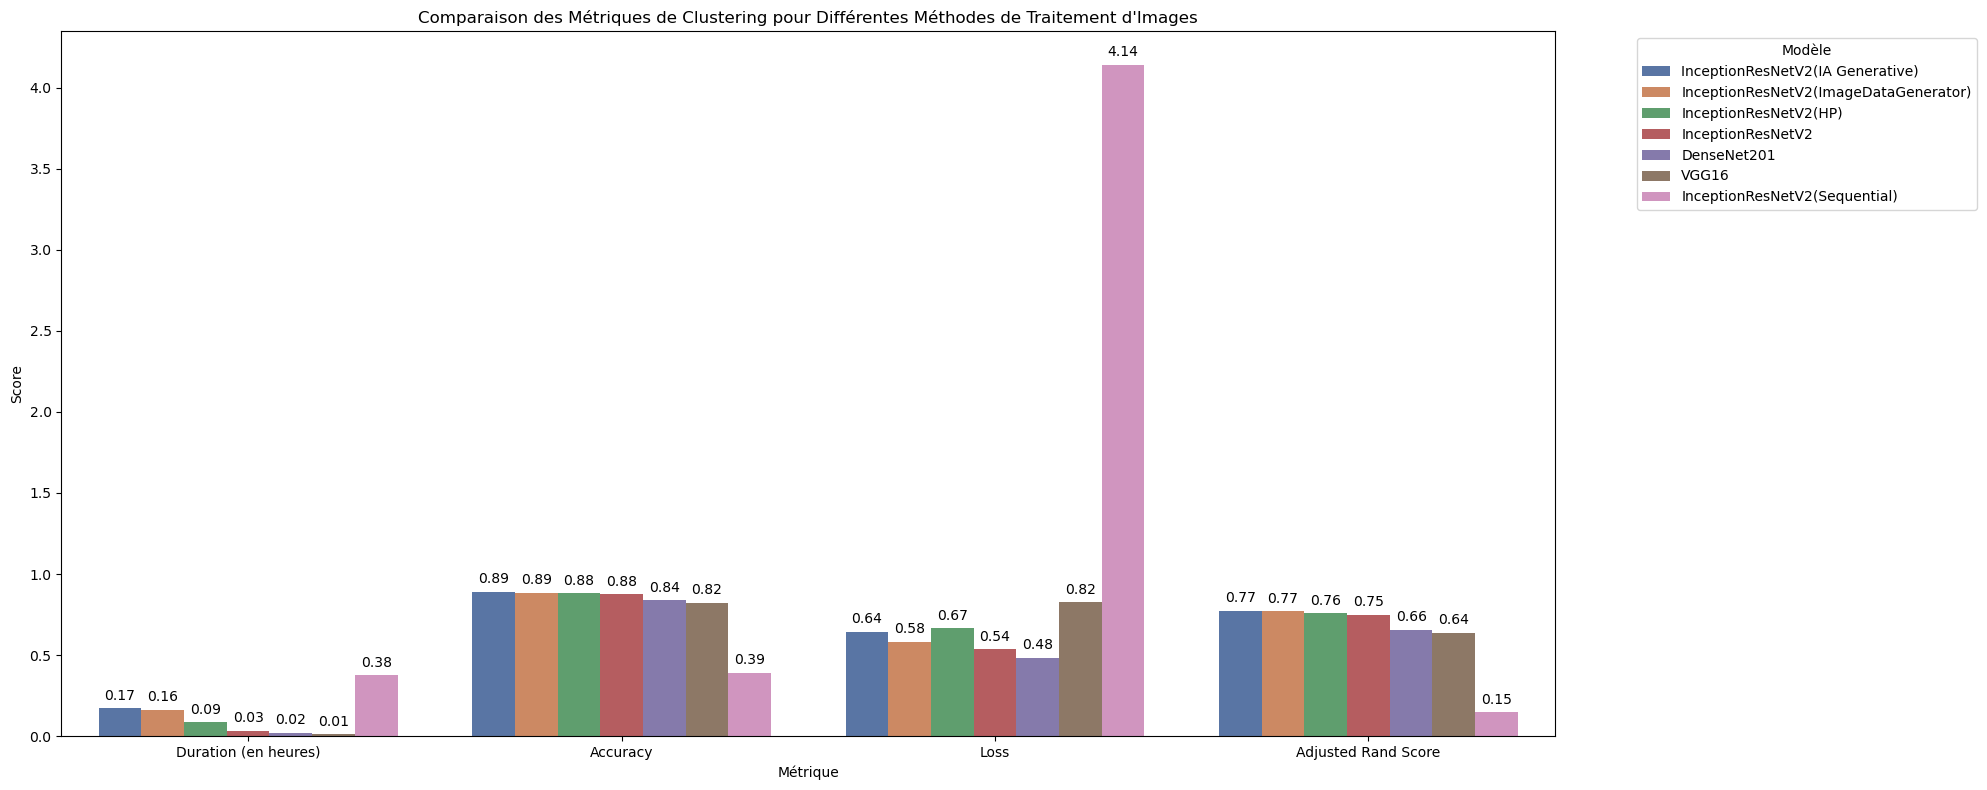

In [59]:
plot_model_performance(data_metrics)